# Lecture 09: Regression Based Forecsating


## Import Libs

In [1]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import statsmodels
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools, stattools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics import tsaplots

In [2]:
my_drive_path = "/content/drive/MyDrive/SUNY/Class Material/2024 Fall/MSA550A/Python Class Work/msa550-code-files/data/"

## Sampling Explanation (Undersampling & Oversampling)

In [7]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split


# Load and prepare the data
bank_df = pd.read_csv(my_drive_path + 'UniversalBank.csv')
bank_df = bank_df.drop(columns=['ID', 'ZIP Code'])

# Drop any rows with missing values
bank_df = bank_df.dropna()

X = bank_df.drop(columns=['Personal Loan'])
y = bank_df['Personal Loan']

In [8]:
# Check class distribution in the training set
print("Original class distribution:", Counter(y))

Original class distribution: Counter({0: 4520, 1: 480})


In [10]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Check class distribution in the training set
print("Original class distribution:", Counter(y_train))

Original class distribution: Counter({0: 3164, 1: 336})


In [11]:
# Perform undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

# Check class distribution after undersampling
print("Class distribution after undersampling:", Counter(y_train_under))

Class distribution after undersampling: Counter({0: 336, 1: 336})


In [13]:
# Perform oversampling
oversampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)

# Check class distribution after oversampling
print("Class distribution after oversampling:", Counter(y_train_over))

Class distribution after oversampling: Counter({0: 3164, 1: 3164})


## Load Data

In [15]:
# Load data and convert to time series
Amtrak_df = pd.read_csv(my_drive_path+'Amtrak.csv')

Amtrak_df

,Month,Ridership
0,01/01/1991,1708.917
1,01/02/1991,1620.586
2,01/03/1991,1972.715
3,01/04/1991,1811.665
4,01/05/1991,1974.964
...,...,...
154,01/11/2003,2076.054
155,01/12/2003,2140.677
156,01/01/2004,1831.508
157,01/02/2004,1838.006


In [16]:
Amtrak_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Month      159 non-null    object 
 1   Ridership  159 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.6+ KB


In [ ]:
#fixes needed on the TS dataset

# Convert to time series
Amtrak_df['Date'] = pd.to_datetime(Amtrak_df['Month'], format='%d/%m/%Y')
Amtrak_df.set_index('Date', inplace=True)
ridership_ts = pd.Series(Amtrak_df['Ridership'].values, index=Amtrak_df.index, name='Ridership')

## Linear Trend on Amtrak Ridership Data

**Possible Trends**
* 'n' add no trend.  Formula: Ridership ~ 1   (1 is the constant term)
* 'c' add constant only.  Formula: Ridership ~ 1   (1 is the constant term)
* 't' add trend only.   Formula: Ridership ~  trend
* 'ct' add constant and linear trend. Formula: Ridership ~ 1 + trend
* 'ctt' add constant and linear and quadratic trend. Formula: Ridership ~ 1 + trend + np.square(trend)
* 'cttt' add Constant, Linear, Quadratic, and Cubic Trend      Formula: Ridership ~ 1 + trend + np.square(trend) + np.power(trend, 3)



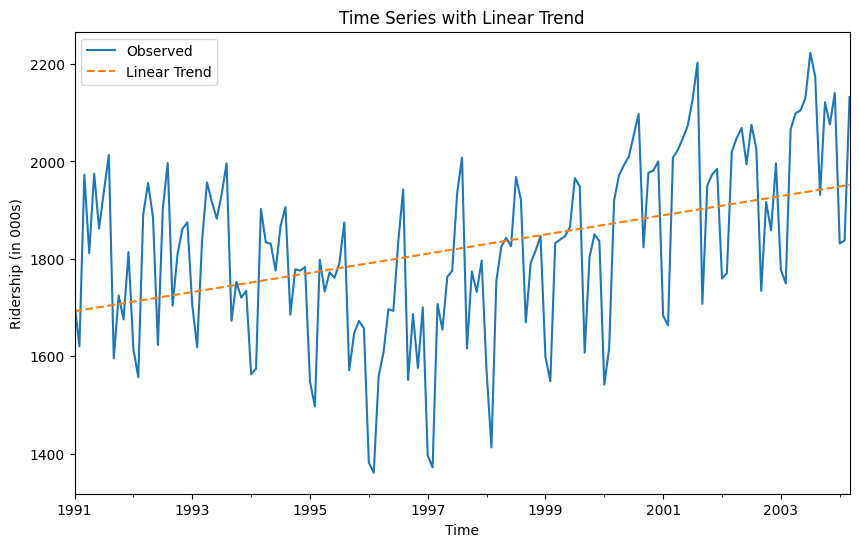

In [17]:
# Add linear trend (constant + time)
ridership_df_linear = tsatools.add_trend(ridership_ts, trend='ct')  # 'ct' adds constant + linear trend
formula_linear = 'Ridership ~ 1 + trend'

# Fit linear model
model_linear = sm.ols(formula=formula_linear, data=ridership_df_linear).fit()

# Generate predictions
ridership_df_linear['Fitted'] = model_linear.predict(ridership_df_linear)

# Plot observed vs fitted for linear trend
ax = ridership_ts.plot(label='Observed', figsize=(10, 6))
ridership_df_linear['Fitted'].plot(ax=ax, label='Linear Trend', linestyle='--')
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')
ax.legend()
plt.title("Time Series with Linear Trend")
plt.show()


## Quadratic Trend on Amtrak Ridership Data

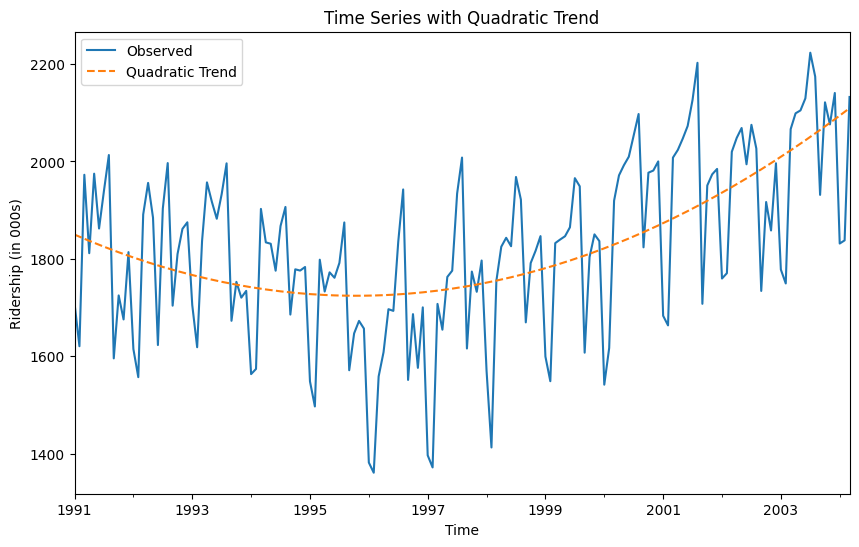

In [18]:
# Add quadratic trend (constant + linear + quadratic)
ridership_df_quad = tsatools.add_trend(ridership_ts, trend='ctt')  # 'ctt' adds constant + linear + quadratic trend
formula_quad = 'Ridership ~ 1 + trend + np.square(trend)'

# Fit quadratic model
model_quad = sm.ols(formula=formula_quad, data=ridership_df_quad).fit()

# Generate predictions
ridership_df_quad['Fitted'] = model_quad.predict(ridership_df_quad)

# Plot observed vs fitted for quadratic trend
ax = ridership_ts.plot(label='Observed', figsize=(10, 6))
ridership_df_quad['Fitted'].plot(ax=ax, label='Quadratic Trend', linestyle='--')
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')
ax.legend()
plt.title("Time Series with Quadratic Trend")
plt.show()


## Compare Linear and Quadratic Trends

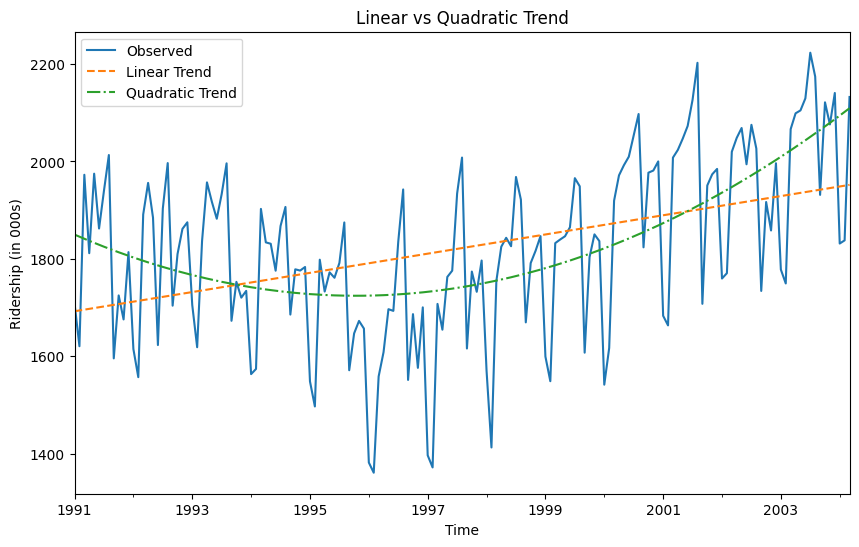

In [19]:
ax = ridership_ts.plot(label='Observed', figsize=(10, 6))
ridership_df_linear['Fitted'].plot(ax=ax, label='Linear Trend', linestyle='--')
ridership_df_quad['Fitted'].plot(ax=ax, label='Quadratic Trend', linestyle='-.')
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')
ax.legend()
plt.title("Linear vs Quadratic Trend")
plt.show()


Evaluate Model Performance

In [20]:
print("Linear Trend Summary:")
print(model_linear.summary())

print("\nQuadratic Trend Summary:")
print(model_quad.summary())


Linear Trend Summary:
                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     32.92
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           4.80e-08
Time:                        21:03:58   Log-Likelihood:                -1037.1
No. Observations:                 159   AIC:                             2078.
Df Residuals:                     157   BIC:                             2084.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1690.7983     26.4

## Generalized Function for Trends

In [21]:
def plot_trend(data, time_col, value_col, trend_type='ct', date_format=None, ylim=None):
    """
    Plot a time series with a specified trend type, allowing for custom date formats.

    Parameters:
    - data: pd.DataFrame, the dataset containing time and value columns.
    - time_col: str, name of the column containing the time index.
    - value_col: str, name of the column containing the values to model.
    - trend_type: str, trend specification ('n', 'c', 't', 'ct', 'ctt', 'cttt').
    - date_format: str, the date format used in the time column (optional).
    - ylim: tuple, y-axis limits for the plot (optional).
    """
    # Convert the time column to a DatetimeIndex
    data['Date'] = pd.to_datetime(data[time_col], format=date_format)
    data.set_index('Date', inplace=True)
    #print("Data Head:\n", data.head())  # Debugging step: check data structure

    # Convert to time series
    ts = pd.Series(data[value_col].values, index=data.index, name=value_col)
    #print("\nTime Series Head:\n", ts.head())  # Debugging step: check time series

    # Define trend formulas
    trend_terms = {
        'n': '1',
        'c': '1',
        't': 'trend',
        'ct': '1 + trend',
        'ctt': '1 + trend + np.square(trend)',
        'cttt': '1 + trend + np.square(trend) + np.power(trend, 3)'
    }

    if trend_type not in trend_terms:
        raise ValueError("Invalid trend_type. Choose from 'n', 'c', 't', 'ct', 'ctt', 'cttt'.")

    trend_formula = f"{value_col} ~ {trend_terms[trend_type]}"

    # Add trend terms to the time series
    ts_df = tsatools.add_trend(ts, trend=trend_type)
    #print("\nTrend Data Head:\n", ts_df.head())  # Debugging step: check trend terms

    # Fit the model
    model = sm.ols(formula=trend_formula, data=ts_df).fit()
    #print("\nModel Summary:\n", model.summary())  # Debugging step: check model results

    # Generate predictions
    ts_df['Fitted'] = model.predict(ts_df)

    # Plot observed vs fitted
    plt.figure(figsize=(12, 6))
    ax = ts.plot(label='Observed', linewidth=2)
    ts_df['Fitted'].plot(ax=ax, label=f'{trend_type.upper()} Trend', linestyle='--', linewidth=2)
    ax.set_xlabel('Time')
    ax.set_ylabel(value_col)
    if ylim:
        ax.set_ylim(*ylim)
    ax.legend()
    plt.title(f"Time Series with {trend_type.upper()} Trend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model


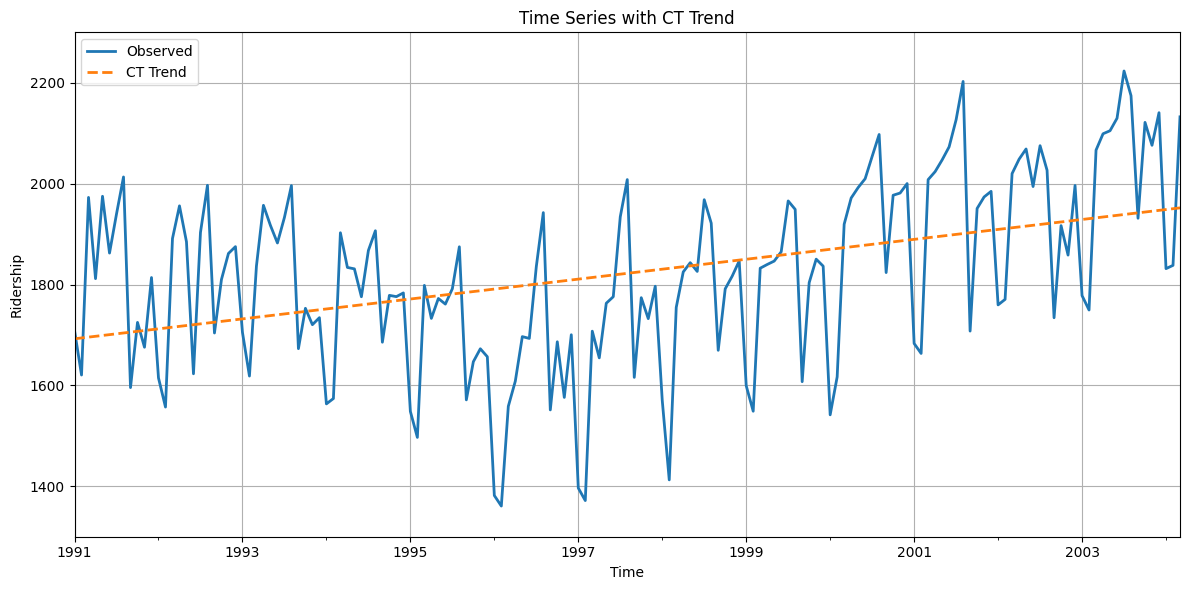

In [22]:
model_linear = plot_trend(
    data=Amtrak_df,
    time_col='Month',
    value_col='Ridership',
    trend_type='ct',
    date_format='%d/%m/%Y',
    ylim=(1300, 2300)
)

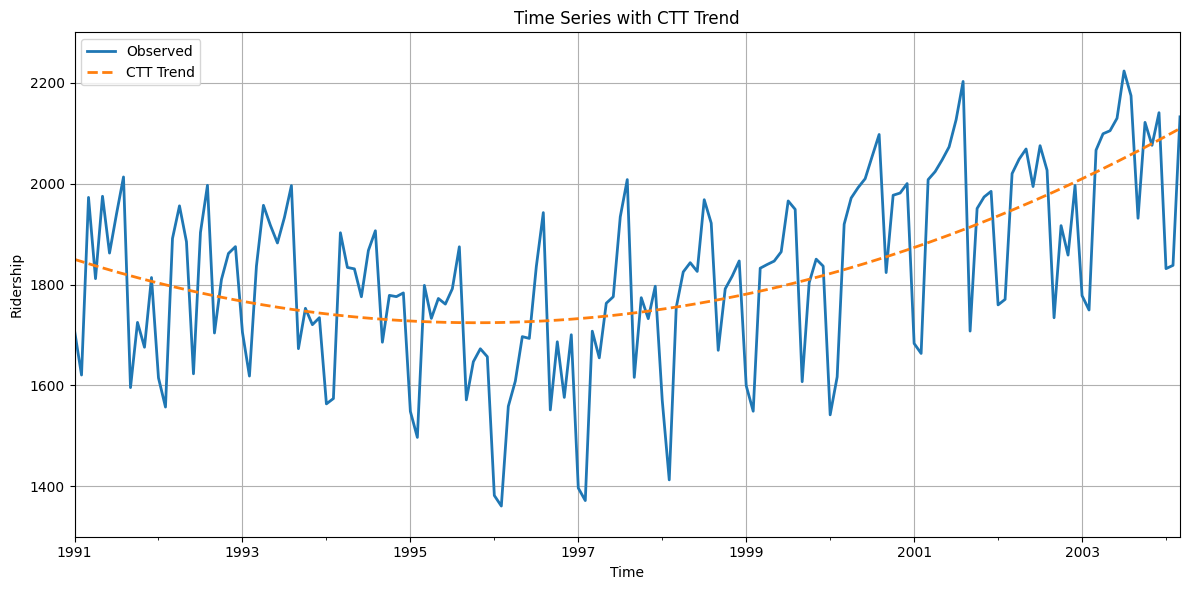

In [23]:
model_quadratic = plot_trend(
    data=Amtrak_df,
    time_col='Month',         # Column name containing the time information
    value_col='Ridership',    # Column name containing the values
    trend_type='ctt',         # Use quadratic trend
    date_format='%d/%m/%Y',   # Specify the non-standard date format
    ylim=(1300, 2300)         # Optional y-axis limits
)


## Plotting Predictions for the Linear Trend

In [28]:
# Plot Layout Functions
def singleGraphLayout(ax, ylim, train_df, valid_df):
    ax.set_xlim(train_df.index.min(), valid_df.index.max())
    ax.set_ylim(*ylim)
    ax.set_xlabel('Time')

    # Highlight Training and Validation Periods
    ax.axvline(train_df.index.max(), color='black', linestyle='--', linewidth=1)
    ax.fill_betweenx(ylim, train_df.index.min(), train_df.index.max(), alpha=0.1, label="Training Period", color="blue")
    ax.fill_betweenx(ylim, valid_df.index.min(), valid_df.index.max(), alpha=0.1, label="Validation Period", color="orange")

    ax.legend()

def graphLayout(axes, train_df, valid_df):
    singleGraphLayout(axes[0], [1300, 2600], train_df, valid_df)
    singleGraphLayout(axes[1], [-550, 550], train_df, valid_df)

    # Plot Observed and Predicted Values
    train_df.plot(y='Ridership', ax=axes[0], color='blue', linewidth=1, label='Observed (Train)')
    valid_df.plot(y='Ridership', ax=axes[0], color='orange', linestyle='dashed', linewidth=1, label='Observed (Validation)')
    train_df.plot(y='Predicted', ax=axes[0], color='red', linestyle='-', label='Predicted (Train)')
    valid_df.plot(y='Predicted', ax=axes[0], color='red', linestyle='dashed', label='Predicted (Validation)')

    # Plot Residuals
    train_residuals = train_df['Ridership'] - train_df['Predicted']
    valid_residuals = valid_df['Ridership'] - valid_df['Predicted']
    train_residuals.plot(ax=axes[1], color='blue', linewidth=1, label='Residuals (Train)')
    valid_residuals.plot(ax=axes[1], color='orange', linestyle='dashed', linewidth=1, label='Residuals (Validation)')

    axes[1].axhline(0, color='black', linestyle='--', linewidth=0.5)  # Zero line for residuals

    # Add Titles and Labels
    axes[0].set_title("Observed vs Predicted: Training and Validation")
    axes[1].set_title("Residuals: Training and Validation")
    axes[0].set_ylabel("Ridership")
    axes[1].set_ylabel("Residuals")

    # Add Legends
    axes[0].legend()
    axes[1].legend()

In [39]:
# Load data and convert to time series
Amtrak_df = pd.read_csv(my_drive_path+'Amtrak.csv')
Amtrak_df['Date'] = pd.to_datetime(Amtrak_df.Month, format='%d/%m/%Y')
ridership_ts = pd.Series(Amtrak_df.Ridership.values, index=Amtrak_df.Date, name='Ridership')
ridership_ts.index = pd.DatetimeIndex(ridership_ts.index, freq=ridership_ts.index.inferred_freq)


trend_type = 'ctt'
trend_formula = 'Ridership ~ 1 + trend + np.square(trend)'

# fit a linear trend model to the time series
ridership_df = tsatools.add_trend(ridership_ts, trend=trend_type)
ridership_lm = sm.ols(formula=trend_formula, data=ridership_df).fit()


In [40]:
# Partitioning the Data
nValid = 36  # Validation set size
nTrain = len(ridership_ts) - nValid  # Training set size

# Create explicit copies of training and validation sets
train_df = ridership_df[:nTrain].copy()
valid_df = ridership_df[nTrain:].copy()

# Add predictions for training and validation sets
train_df.loc[:, 'Predicted'] = ridership_lm.predict(train_df)
valid_df.loc[:, 'Predicted'] = ridership_lm.predict(valid_df)

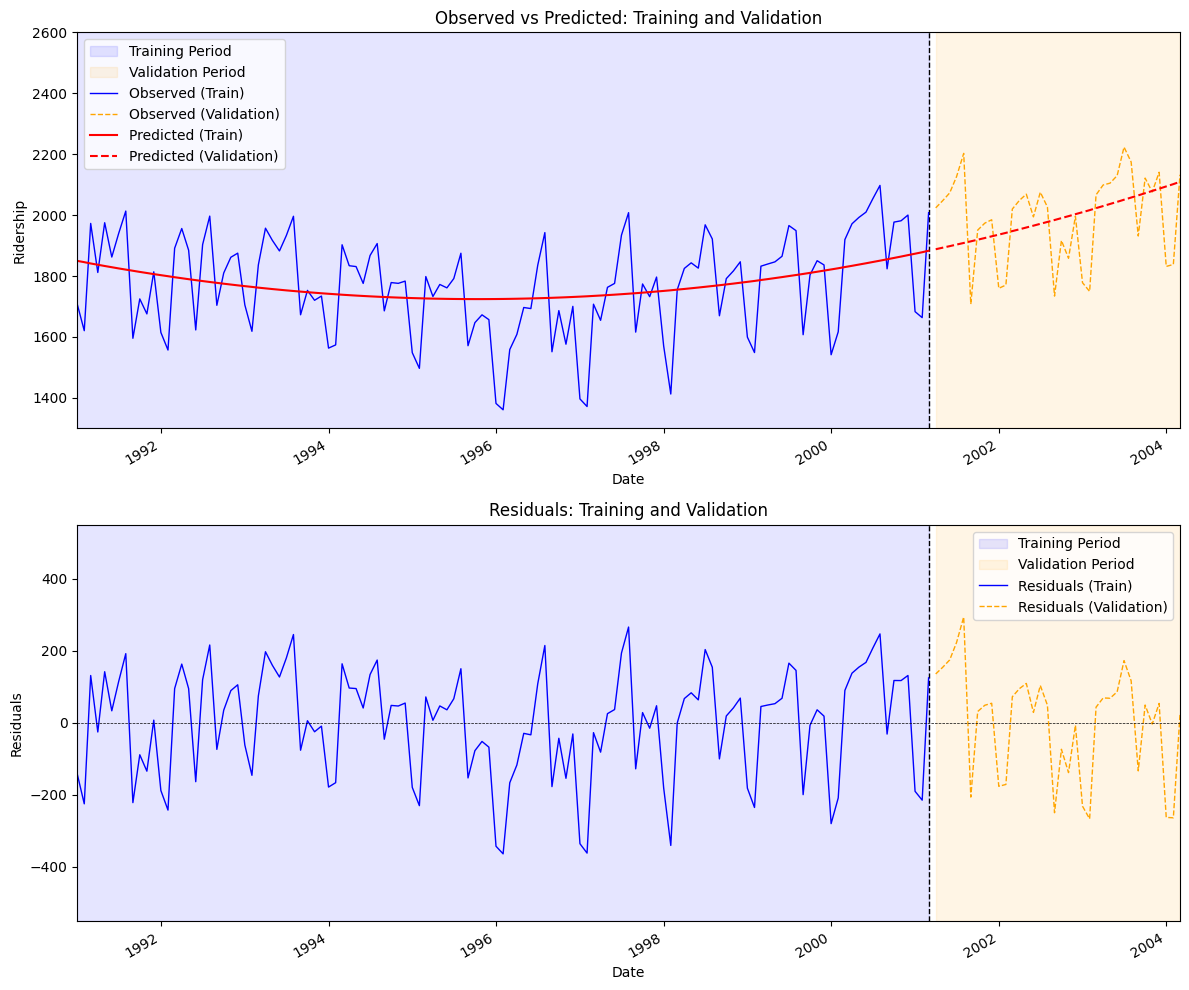

                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     38.48
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           2.61e-14
Time:                        21:18:41   Log-Likelihood:                -1020.4
No. Observations:                 159   AIC:                             2047.
Df Residuals:                     156   BIC:                             2056.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1854.2646     36.042  

In [41]:
# Plot the Results
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
graphLayout(axes, train_df, valid_df)
plt.tight_layout()
plt.show()

# Print Model Summary
print(ridership_lm.summary())

## Investigating an Exponential Trend

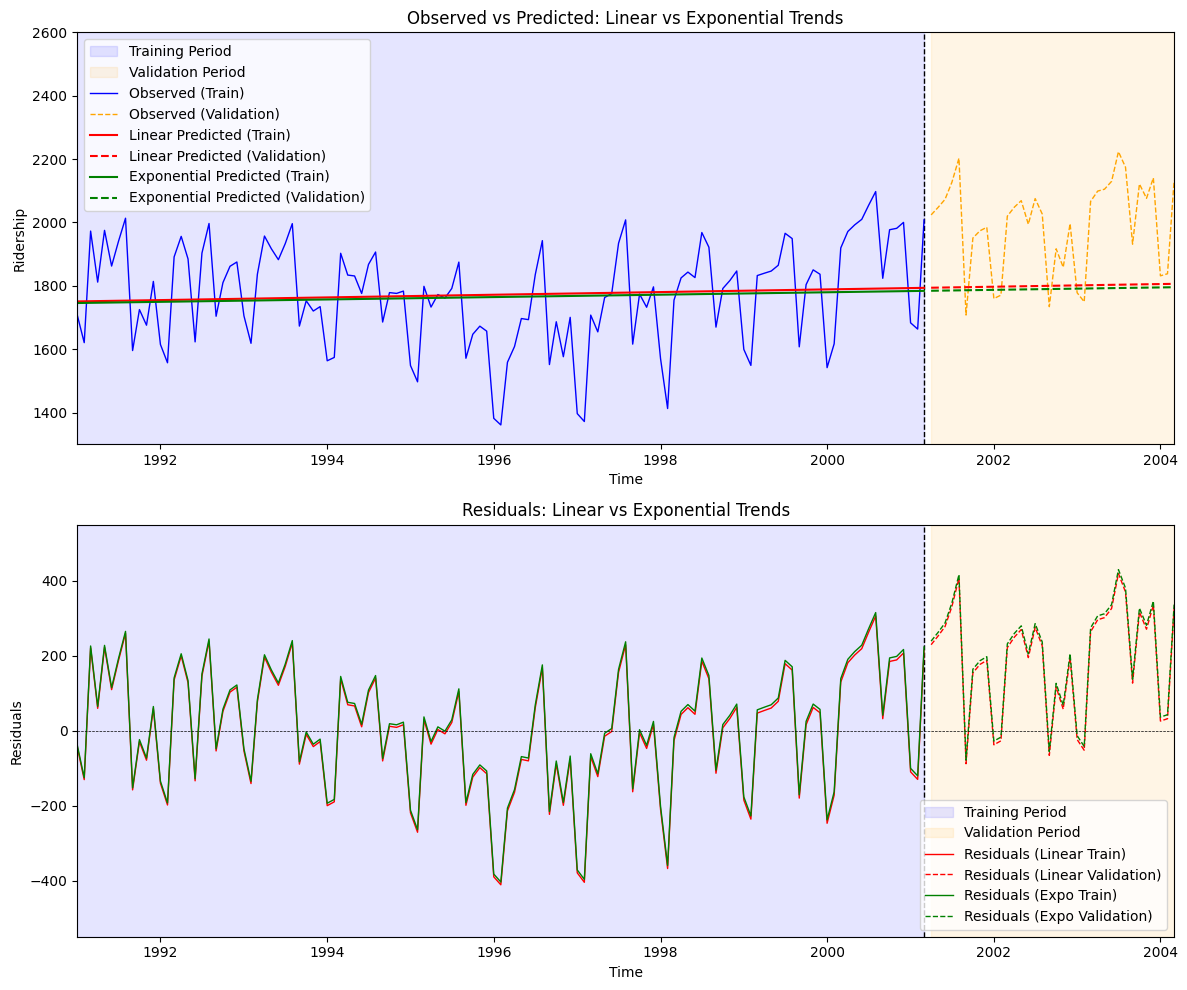

Linear Model Summary:
                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7456
Date:                Wed, 20 Nov 2024   Prob (F-statistic):              0.390
Time:                        21:23:08   Log-Likelihood:                -797.95
No. Observations:                 123   AIC:                             1600.
Df Residuals:                     121   BIC:                             1606.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1750.3595     29.0

In [44]:

# Linear Trend: Fit model
ridership_lm_linear = sm.ols(formula='Ridership ~ trend', data=train_df).fit()

# Exponential Trend: Transform Ridership to log(Y)
ridership_lm_expo = sm.ols(formula='np.log(Ridership) ~ trend', data=train_df).fit()

# Predictions: Transform log(Y) back to original scale for exponential trend
train_df['Predicted_Linear'] = ridership_lm_linear.predict(train_df)
valid_df['Predicted_Linear'] = ridership_lm_linear.predict(valid_df)

train_df['Predicted_Expo'] = ridership_lm_expo.predict(train_df).apply(math.exp)
valid_df['Predicted_Expo'] = ridership_lm_expo.predict(valid_df).apply(math.exp)

# Calculate Residuals
train_df['Residual_Linear'] = train_df['Ridership'] - train_df['Predicted_Linear']
valid_df['Residual_Linear'] = valid_df['Ridership'] - valid_df['Predicted_Linear']

train_df['Residual_Expo'] = train_df['Ridership'] - train_df['Predicted_Expo']
valid_df['Residual_Expo'] = valid_df['Ridership'] - valid_df['Predicted_Expo']

# Plot Layout Functions
def singleGraphLayout(ax, ylim, train_df, valid_df):
    ax.set_xlim(train_df.index.min(), valid_df.index.max())
    ax.set_ylim(*ylim)
    ax.set_xlabel('Time')

    # Highlight Training and Validation Periods
    ax.axvline(train_df.index.max(), color='black', linestyle='--', linewidth=1)
    ax.fill_betweenx(ylim, train_df.index.min(), train_df.index.max(), alpha=0.1, label="Training Period", color="blue")
    ax.fill_betweenx(ylim, valid_df.index.min(), valid_df.index.max(), alpha=0.1, label="Validation Period", color="orange")

    ax.legend()

def graphLayout(axes, train_df, valid_df):
    singleGraphLayout(axes[0], [1300, 2600], train_df, valid_df)
    singleGraphLayout(axes[1], [-550, 550], train_df, valid_df)

    # Plot Observed and Predicted Values
    axes[0].plot(train_df.index, train_df['Ridership'], color='blue', linewidth=1, label='Observed (Train)')
    axes[0].plot(valid_df.index, valid_df['Ridership'], color='orange', linestyle='dashed', linewidth=1, label='Observed (Validation)')
    axes[0].plot(train_df.index, train_df['Predicted_Linear'], color='red', linestyle='-', label='Linear Predicted (Train)')
    axes[0].plot(valid_df.index, valid_df['Predicted_Linear'], color='red', linestyle='dashed', label='Linear Predicted (Validation)')
    axes[0].plot(train_df.index, train_df['Predicted_Expo'], color='green', linestyle='-', label='Exponential Predicted (Train)')
    axes[0].plot(valid_df.index, valid_df['Predicted_Expo'], color='green', linestyle='dashed', label='Exponential Predicted (Validation)')

    # Plot Residuals for Both Models
    axes[1].plot(train_df.index, train_df['Residual_Linear'], color='red', linewidth=1, label='Residuals (Linear Train)')
    axes[1].plot(valid_df.index, valid_df['Residual_Linear'], color='red', linestyle='dashed', linewidth=1, label='Residuals (Linear Validation)')
    axes[1].plot(train_df.index, train_df['Residual_Expo'], color='green', linewidth=1, label='Residuals (Expo Train)')
    axes[1].plot(valid_df.index, valid_df['Residual_Expo'], color='green', linestyle='dashed', linewidth=1, label='Residuals (Expo Validation)')

    axes[1].axhline(0, color='black', linestyle='--', linewidth=0.5)  # Zero line for residuals

    # Add Titles and Labels
    axes[0].set_title("Observed vs Predicted: Linear vs Exponential Trends")
    axes[1].set_title("Residuals: Linear vs Exponential Trends")
    axes[0].set_ylabel("Ridership")
    axes[1].set_ylabel("Residuals")

    # Add Legends
    axes[0].legend()
    axes[1].legend()

# Plot the Results
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
graphLayout(axes, train_df, valid_df)
plt.tight_layout()
plt.show()

# Print Model Summaries
print("Linear Model Summary:")
print(ridership_lm_linear.summary())
print("\nExponential Model Summary:")
print(ridership_lm_expo.summary())

### Remember to Transform the Result Back When Using Exp

In [45]:
predict_df_linear = ridership_lm_linear.predict(valid_df)
predict_df_linear.head()

,0
Date,
2001-04-01,1793.929679
2001-05-01,1794.281051
2001-06-01,1794.632424
2001-07-01,1794.983796
2001-08-01,1795.335168


In [46]:
predict_df_expo = ridership_lm_expo.predict(valid_df)
predict_df_expo.head()

,0
Date,
2001-04-01,7.486813
2001-05-01,7.486991
2001-06-01,7.487170
2001-07-01,7.487348
2001-08-01,7.487526


In [47]:
#don't forget to format it back if you are using exp trend
predict_df_expo.apply(lambda row: math.exp(row)).head()

,0
Date,
2001-04-01,1784.356066
2001-05-01,1784.674328
2001-06-01,1784.992648
2001-07-01,1785.311024
2001-08-01,1785.629457


## Investigating the Polynomian Trend

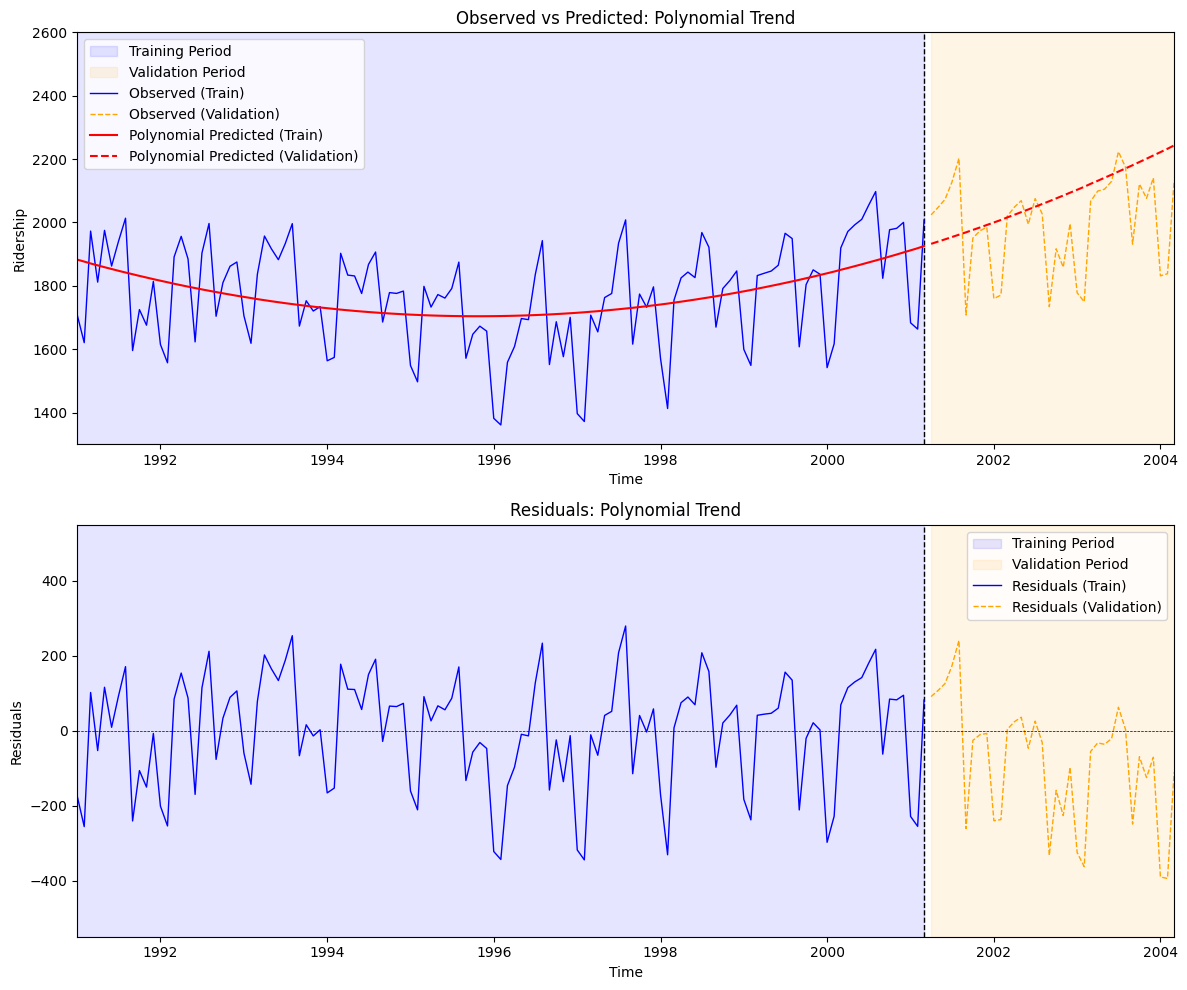

                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     10.58
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           5.84e-05
Time:                        21:26:20   Log-Likelihood:                -788.33
No. Observations:                 123   AIC:                             1583.
Df Residuals:                     120   BIC:                             1591.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1888.8840     40.915  

In [48]:


# Polynomial Model: Include quadratic term
ridership_lm_poly = sm.ols(formula='Ridership ~ trend + np.square(trend)', data=train_df).fit()

# Predictions
train_df['Predicted_Poly'] = ridership_lm_poly.predict(train_df)
valid_df['Predicted_Poly'] = ridership_lm_poly.predict(valid_df)

# Residuals
train_df['Residual_Poly'] = train_df['Ridership'] - train_df['Predicted_Poly']
valid_df['Residual_Poly'] = valid_df['Ridership'] - valid_df['Predicted_Poly']

# Plot Layout Functions
def singleGraphLayout(ax, ylim, train_df, valid_df):
    ax.set_xlim(train_df.index.min(), valid_df.index.max())
    ax.set_ylim(*ylim)
    ax.set_xlabel('Time')

    # Highlight Training and Validation Periods
    ax.axvline(train_df.index.max(), color='black', linestyle='--', linewidth=1)
    ax.fill_betweenx(ylim, train_df.index.min(), train_df.index.max(), alpha=0.1, label="Training Period", color="blue")
    ax.fill_betweenx(ylim, valid_df.index.min(), valid_df.index.max(), alpha=0.1, label="Validation Period", color="orange")

    ax.legend()

def graphLayout(axes, train_df, valid_df):
    singleGraphLayout(axes[0], [1300, 2600], train_df, valid_df)
    singleGraphLayout(axes[1], [-550, 550], train_df, valid_df)

    # Plot Observed and Predicted Values
    axes[0].plot(train_df.index, train_df['Ridership'], color='blue', linewidth=1, label='Observed (Train)')
    axes[0].plot(valid_df.index, valid_df['Ridership'], color='orange', linestyle='dashed', linewidth=1, label='Observed (Validation)')
    axes[0].plot(train_df.index, train_df['Predicted_Poly'], color='red', linestyle='-', label='Polynomial Predicted (Train)')
    axes[0].plot(valid_df.index, valid_df['Predicted_Poly'], color='red', linestyle='dashed', label='Polynomial Predicted (Validation)')

    # Plot Residuals
    axes[1].plot(train_df.index, train_df['Residual_Poly'], color='blue', linewidth=1, label='Residuals (Train)')
    axes[1].plot(valid_df.index, valid_df['Residual_Poly'], color='orange', linestyle='dashed', linewidth=1, label='Residuals (Validation)')
    axes[1].axhline(0, color='black', linestyle='--', linewidth=0.5)  # Zero line for residuals

    # Add Titles and Labels
    axes[0].set_title("Observed vs Predicted: Polynomial Trend")
    axes[1].set_title("Residuals: Polynomial Trend")
    axes[0].set_ylabel("Ridership")
    axes[1].set_ylabel("Residuals")

    # Add Legends
    axes[0].legend()
    axes[1].legend()

# Plot the Results
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
graphLayout(axes, train_df, valid_df)
plt.tight_layout()
plt.show()

# Print Model Summary
print(ridership_lm_poly.summary())


Model with Seasonality (Only)

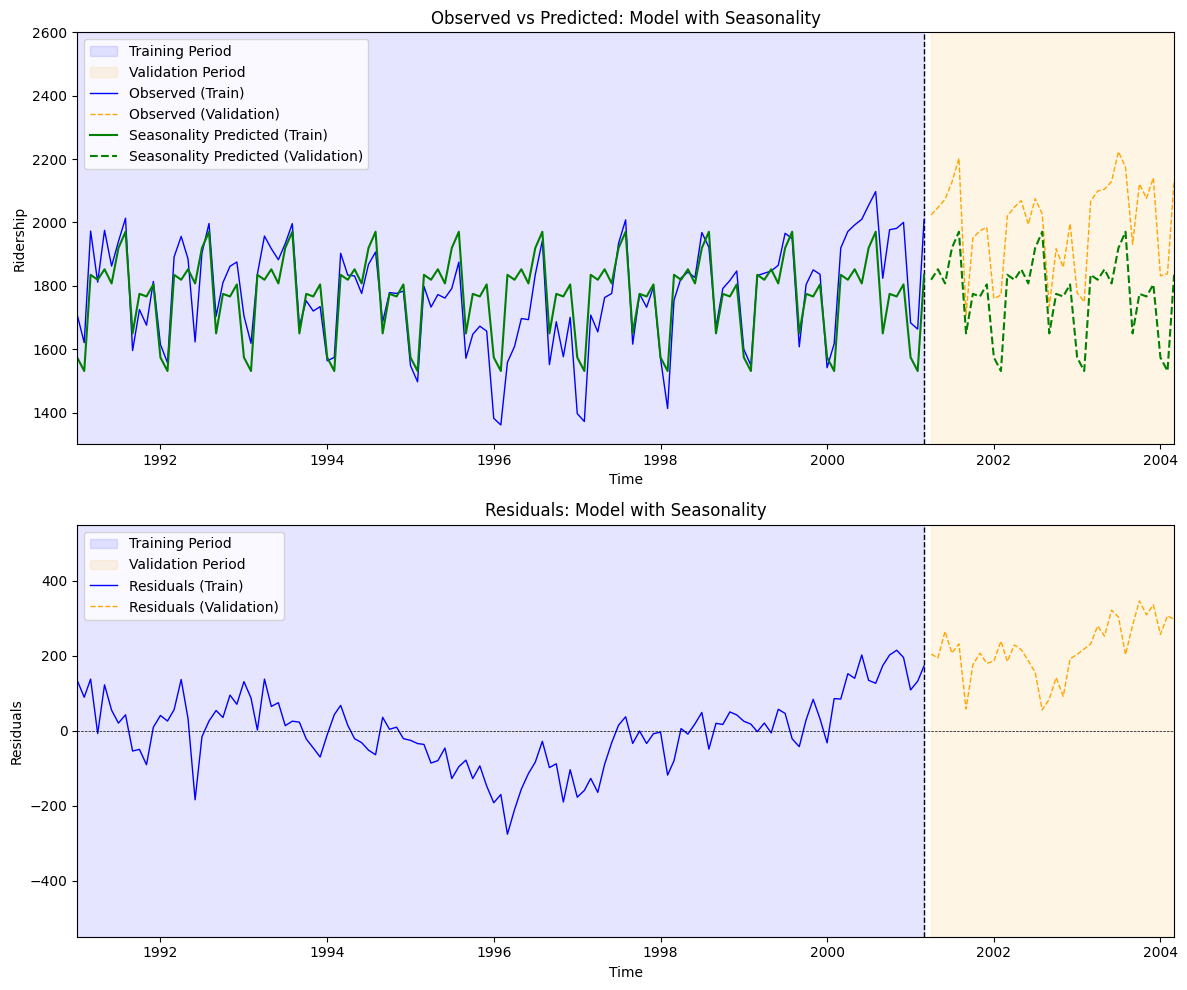

                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     17.54
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           1.20e-19
Time:                        21:28:58   Log-Likelihood:                -736.38
No. Observations:                 123   AIC:                             1497.
Df Residuals:                     111   BIC:                             1531.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1573.9722     30.578     51.

In [49]:
# Add a constant trend and extract the month as a categorical feature
ridership_df = tsatools.add_trend(ridership_ts, trend='ct')
ridership_df['Month'] = ridership_df.index.month

# Partition the data
train_df = ridership_df[:nTrain].copy()  # Use .copy() to avoid SettingWithCopyWarning
valid_df = ridership_df[nTrain:].copy()

# C(Month) treats the 'Month' column as categorical
ridership_lm_season = sm.ols(formula='Ridership ~ C(Month)', data=train_df).fit()

# Predictions
train_df = train_df.copy()  # Ensure we are working with a copy
valid_df = valid_df.copy()  # Ensure we are working with a copy

train_df.loc[:, 'Predicted_Season'] = ridership_lm_season.predict(train_df)
valid_df.loc[:, 'Predicted_Season'] = ridership_lm_season.predict(valid_df)

# Residuals
train_df.loc[:, 'Residual_Season'] = train_df['Ridership'] - train_df['Predicted_Season']
valid_df.loc[:, 'Residual_Season'] = valid_df['Ridership'] - valid_df['Predicted_Season']




# Plot Layout Functions
def singleGraphLayout(ax, ylim, train_df, valid_df):
    ax.set_xlim(train_df.index.min(), valid_df.index.max())
    ax.set_ylim(*ylim)
    ax.set_xlabel('Time')

    # Highlight Training and Validation Periods
    ax.axvline(train_df.index.max(), color='black', linestyle='--', linewidth=1)
    ax.fill_betweenx(ylim, train_df.index.min(), train_df.index.max(), alpha=0.1, label="Training Period", color="blue")
    ax.fill_betweenx(ylim, valid_df.index.min(), valid_df.index.max(), alpha=0.1, label="Validation Period", color="orange")

    ax.legend()

def graphLayout(axes, train_df, valid_df):
    singleGraphLayout(axes[0], [1300, 2600], train_df, valid_df)
    singleGraphLayout(axes[1], [-550, 550], train_df, valid_df)

    # Plot Observed and Predicted Values
    axes[0].plot(train_df.index, train_df['Ridership'], color='blue', linewidth=1, label='Observed (Train)')
    axes[0].plot(valid_df.index, valid_df['Ridership'], color='orange', linestyle='dashed', linewidth=1, label='Observed (Validation)')
    axes[0].plot(train_df.index, train_df['Predicted_Season'], color='green', linestyle='-', label='Seasonality Predicted (Train)')
    axes[0].plot(valid_df.index, valid_df['Predicted_Season'], color='green', linestyle='dashed', label='Seasonality Predicted (Validation)')

    # Plot Residuals
    axes[1].plot(train_df.index, train_df['Residual_Season'], color='blue', linewidth=1, label='Residuals (Train)')
    axes[1].plot(valid_df.index, valid_df['Residual_Season'], color='orange', linestyle='dashed', linewidth=1, label='Residuals (Validation)')
    axes[1].axhline(0, color='black', linestyle='--', linewidth=0.5)  # Zero line for residuals

    # Add Titles and Labels
    axes[0].set_title("Observed vs Predicted: Model with Seasonality")
    axes[1].set_title("Residuals: Model with Seasonality")
    axes[0].set_ylabel("Ridership")
    axes[1].set_ylabel("Residuals")

    # Add Legends
    axes[0].legend()
    axes[1].legend()

# Plot the Results
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
graphLayout(axes, train_df, valid_df)
plt.tight_layout()
plt.show()

# Print Model Summary
print(ridership_lm_season.summary())


## Full Model (Quadratic Trend and Seasonality)

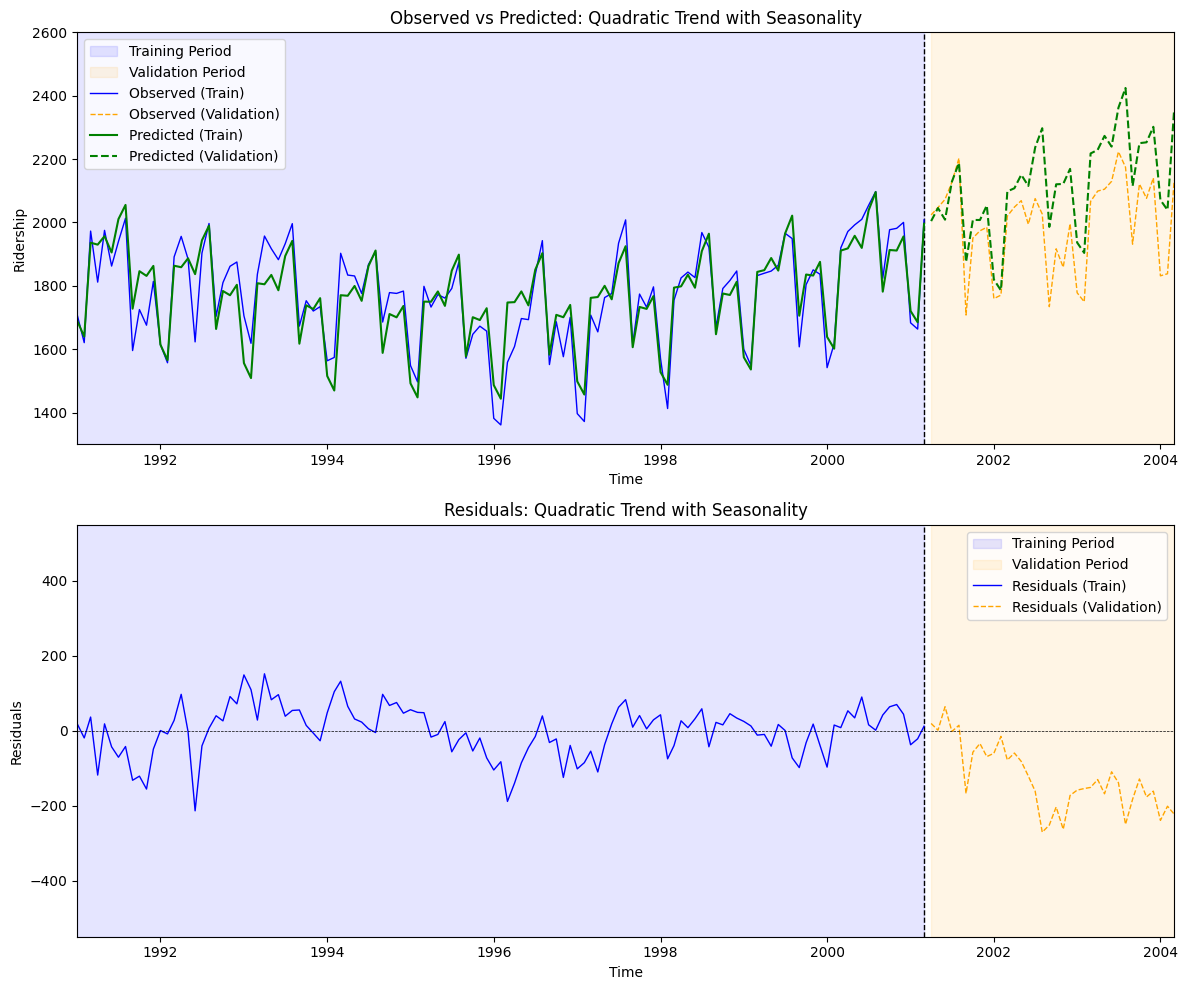

                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     39.42
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           3.75e-35
Time:                        21:31:17   Log-Likelihood:                -691.27
No. Observations:                 123   AIC:                             1411.
Df Residuals:                     109   BIC:                             1450.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1696.9794     27.675  

In [50]:

# Fit the model with quadratic trend and seasonality
ridership_lm_trendseason = sm.ols(formula='Ridership ~ trend + np.square(trend) + C(Month)', data=train_df).fit()

# Add predictions and residuals to the data
train_df['Predicted_TrendSeason'] = ridership_lm_trendseason.predict(train_df)
valid_df['Predicted_TrendSeason'] = ridership_lm_trendseason.predict(valid_df)

train_df['Residual_TrendSeason'] = train_df['Ridership'] - train_df['Predicted_TrendSeason']
valid_df['Residual_TrendSeason'] = valid_df['Ridership'] - valid_df['Predicted_TrendSeason']

# Plot Layout Functions
def singleGraphLayout(ax, ylim, train_df, valid_df):
    ax.set_xlim(train_df.index.min(), valid_df.index.max())
    ax.set_ylim(*ylim)
    ax.set_xlabel('Time')

    # Highlight Training and Validation Periods
    ax.axvline(train_df.index.max(), color='black', linestyle='--', linewidth=1)
    ax.fill_betweenx(ylim, train_df.index.min(), train_df.index.max(), alpha=0.1, label="Training Period", color="blue")
    ax.fill_betweenx(ylim, valid_df.index.min(), valid_df.index.max(), alpha=0.1, label="Validation Period", color="orange")

    ax.legend()

def graphLayout(axes, train_df, valid_df):
    singleGraphLayout(axes[0], [1300, 2600], train_df, valid_df)
    singleGraphLayout(axes[1], [-550, 550], train_df, valid_df)

    # Plot Observed and Predicted Values
    axes[0].plot(train_df.index, train_df['Ridership'], color='blue', linewidth=1, label='Observed (Train)')
    axes[0].plot(valid_df.index, valid_df['Ridership'], color='orange', linestyle='dashed', linewidth=1, label='Observed (Validation)')
    axes[0].plot(train_df.index, train_df['Predicted_TrendSeason'], color='green', linestyle='-', label='Predicted (Train)')
    axes[0].plot(valid_df.index, valid_df['Predicted_TrendSeason'], color='green', linestyle='dashed', label='Predicted (Validation)')

    # Plot Residuals
    axes[1].plot(train_df.index, train_df['Residual_TrendSeason'], color='blue', linewidth=1, label='Residuals (Train)')
    axes[1].plot(valid_df.index, valid_df['Residual_TrendSeason'], color='orange', linestyle='dashed', linewidth=1, label='Residuals (Validation)')
    axes[1].axhline(0, color='black', linestyle='--', linewidth=0.5)  # Zero line for residuals

    # Add Titles and Labels
    axes[0].set_title("Observed vs Predicted: Quadratic Trend with Seasonality")
    axes[1].set_title("Residuals: Quadratic Trend with Seasonality")
    axes[0].set_ylabel("Ridership")
    axes[1].set_ylabel("Residuals")

    # Add Legends
    axes[0].legend()
    axes[1].legend()

# Plot the Results
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
graphLayout(axes, train_df, valid_df)
plt.tight_layout()
plt.show()

# Print Model Summary
print(ridership_lm_trendseason.summary())


## Refitting the model

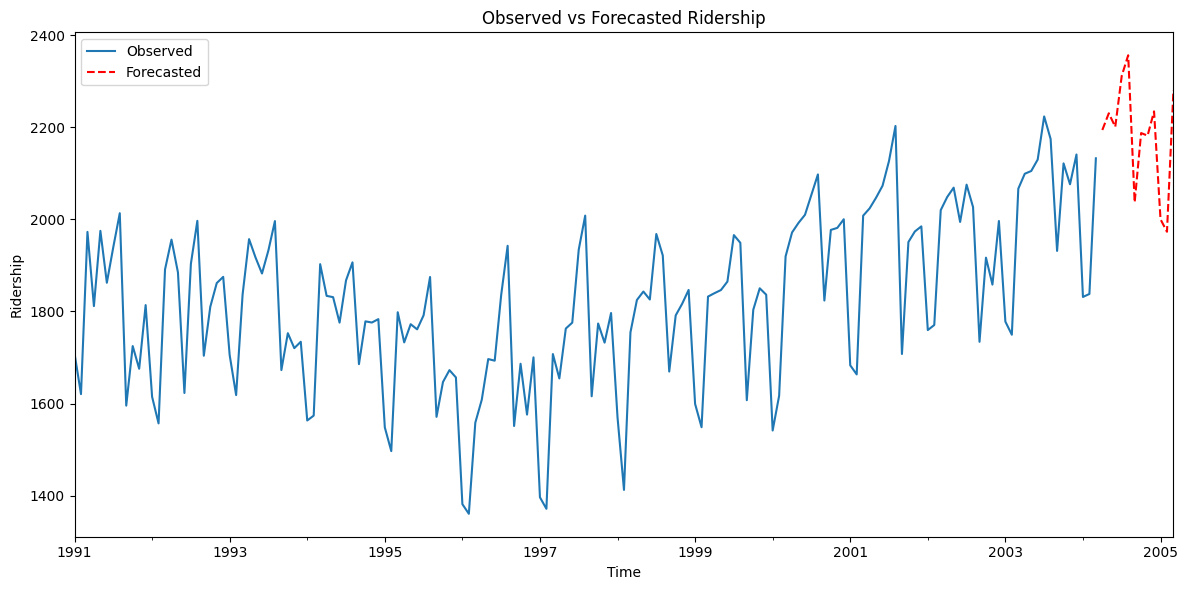

                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     64.82
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           1.24e-53
Time:                        21:34:19   Log-Likelihood:                -899.70
No. Observations:                 159   AIC:                             1827.
Df Residuals:                     145   BIC:                             1870.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1656.3618     25.109  

In [51]:
# Refit the model on the entire dataset
ridership_lm_final = sm.ols(
    formula='Ridership ~ trend + np.square(trend) + C(Month)',
    data=ridership_df
).fit()

# Extend the dataset for forecasting
forecast_periods = 12  # Number of months to forecast
last_date = ridership_df.index[-1]
future_dates = pd.date_range(start=last_date, periods=forecast_periods + 1, freq='MS')[1:]

# Create a DataFrame for future dates
future_df = pd.DataFrame({
    'trend': np.arange(ridership_df['trend'].iloc[-1] + 1, ridership_df['trend'].iloc[-1] + forecast_periods + 1),
    'Month': future_dates.month
}, index=future_dates)

# Generate predictions for the future dates
future_df['Predicted'] = ridership_lm_final.predict(future_df)

# Combine observed and forecasted data for visualization
combined_df = pd.concat([
    ridership_df[['Ridership']],  # Observed data
    future_df[['Predicted']].rename(columns={'Predicted': 'Ridership'})  # Forecasts
])

# Plot observed data and forecasts
ax = ridership_df['Ridership'].plot(label='Observed', figsize=(12, 6))
future_df['Predicted'].plot(ax=ax, label='Forecasted', linestyle='--', color='red')
ax.set_title('Observed vs Forecasted Ridership')
ax.set_ylabel('Ridership')
ax.set_xlabel('Time')
ax.legend()
plt.tight_layout()
plt.show()

# Print summary of the final model
print(ridership_lm_final.summary())

## Autocorrelation and ARIMA
Using linear regression for time series is helpful in catching trend and seasonal patterns. But linear regression does not account for the dependency between values in different periods.
This dependency does not exist in cross-sectional data but in time series it is known as autocorrelation.

'lagged series' is a copy of the original series which is moved forward one or more time periods. For example, a lagged series with lagg-1 is moved forward just 1 time period.

<Figure size 1000x600 with 0 Axes>

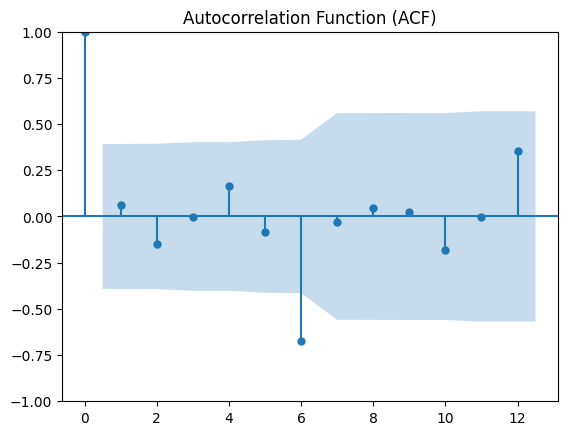

Autocorrelation Analysis:
    Lag       ACF  Lower CI  Upper CI
0     0  1.000000  1.000000  1.000000
1     1  0.063544 -0.328449  0.455537
2     2 -0.149499 -0.543071  0.244074
3     3 -0.003030 -0.405233  0.399174
4     4  0.165998 -0.236209  0.568206
5     5 -0.085984 -0.498584  0.326616
6     6 -0.675579 -1.090923 -0.260234
7     7 -0.028274 -0.587535  0.530986
8     8  0.045446 -0.514034  0.604926
9     9  0.024486 -0.535561  0.584533
10   10 -0.182791 -0.743003  0.377420
11   11 -0.004002 -0.573304  0.565300
12   12  0.355455 -0.213851  0.924762

Key Insights:
- Lag 0 always has ACF = 1 (correlation with itself).
- Significant autocorrelation at lags: [0, 6]


In [52]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import pandas as pd

# Define a function for autocorrelation analysis
def analyze_autocorrelation(data, start_date=None, end_date=None, lags=20):
    """
    Analyze and visualize autocorrelation in a time series.

    Parameters:
    - data: pd.Series, the time series data.
    - start_date: str, optional, start of the period to analyze (format: 'YYYY-MM-DD').
    - end_date: str, optional, end of the period to analyze (format: 'YYYY-MM-DD').
    - lags: int, optional, number of lags to include in the ACF plot.

    Returns:
    - acf_values: pd.DataFrame, ACF values with lags.
    """
    # Slice data for the specified range
    if start_date and end_date:
        data = data[start_date:end_date]

    # Generate ACF plot
    plt.figure(figsize=(10, 6))
    plot_acf(data, lags=lags, title="Autocorrelation Function (ACF)")
    plt.show()

    # Calculate ACF values
    acf_values, confint = acf(data, nlags=lags, alpha=0.05)

    # Create a DataFrame for ACF values
    acf_df = pd.DataFrame({
        'Lag': range(len(acf_values)),
        'ACF': acf_values,
        'Lower CI': confint[:, 0],
        'Upper CI': confint[:, 1]
    })

    # Print summary and highlight significant lags
    print("Autocorrelation Analysis:")
    print(acf_df)
    print("\nKey Insights:")
    print("- Lag 0 always has ACF = 1 (correlation with itself).")
    significant_lags = acf_df[(acf_df['Lower CI'] > 0) | (acf_df['Upper CI'] < 0)]
    if not significant_lags.empty:
        print(f"- Significant autocorrelation at lags: {significant_lags['Lag'].tolist()}")
    else:
        print("- No significant autocorrelation detected.")

    return acf_df

# Example usage
acf_results = analyze_autocorrelation(train_df['Ridership'], start_date='1991-01-01', end_date='1993-01-01', lags=12)


## Residual Autocorrelation

Calculated Residuals:

* Difference between observed and predicted values.
* Residuals represent the unexplained variation in the data.

Autocorrelation Analysis:

* Plotted the ACF to check for dependencies in residuals.

<Figure size 1000x600 with 0 Axes>

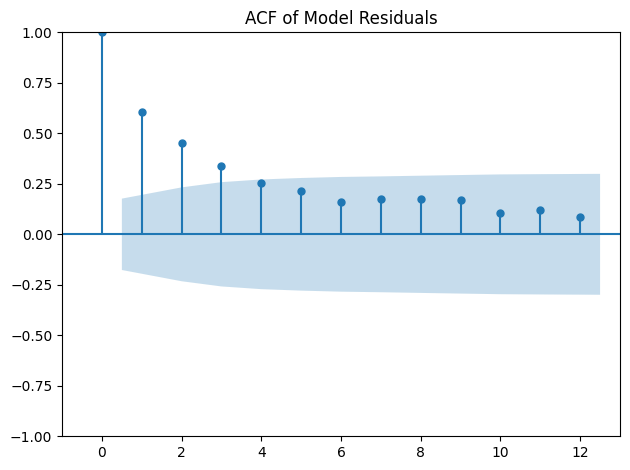

Autocorrelation in Residuals:
    Lag       ACF  Lower CI  Upper CI
0     0  1.000000  1.000000  1.000000
1     1  0.604059  0.427335  0.780783
2     2  0.449832  0.217403  0.682261
3     3  0.337308  0.079118  0.595499
4     4  0.253290 -0.018315  0.524895
5     5  0.215658 -0.063226  0.494543
6     6  0.159013 -0.125032  0.443059
7     7  0.176767 -0.110045  0.463579
8     8  0.175538 -0.114657  0.465732
9     9  0.171409 -0.122083  0.464901
10   10  0.107395 -0.189207  0.403997
11   11  0.119765 -0.178049  0.417579
12   12  0.085129 -0.214185  0.384444
Significant autocorrelation at lags: [0, 1, 2, 3]


In [53]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

# Calculate residuals
residual = train_df['Ridership'] - ridership_lm_trendseason.predict(train_df)

# Visualize ACF of residuals
plt.figure(figsize=(10, 6))
plot_acf(residual, lags=12, title="ACF of Model Residuals")
plt.xlim(-1, 13)  # Set lag range
plt.tight_layout()
plt.show()

# Compute ACF values
acf_values, confint = acf(residual, nlags=12, alpha=0.05)
acf_df = pd.DataFrame({
    'Lag': range(len(acf_values)),
    'ACF': acf_values,
    'Lower CI': confint[:, 0],
    'Upper CI': confint[:, 1]
})

# Print ACF summary
print("Autocorrelation in Residuals:")
print(acf_df)

# Highlight significant lags
significant_lags = acf_df[(acf_df['Lower CI'] > 0) | (acf_df['Upper CI'] < 0)]
if not significant_lags.empty:
    print(f"Significant autocorrelation at lags: {significant_lags['Lag'].tolist()}")
else:
    print("No significant autocorrelation detected in residuals.")


In [ ]:
## ARIMA (AR1) Model

In [54]:
# Define the formula to include trend, quadratic trend, and seasonality (categorical month variable)
formula = 'Ridership ~ trend + np.square(trend) + C(Month)'

# Step 1: Fit the regression model to capture trend and seasonality
train_lm_trendseason = sm.ols(formula=formula, data=train_df).fit()

# Step 2: Fit an AR(1) model to the residuals of the regression model
# ARIMA(order=(1, 0, 0)) specifies an AR(1) model (autoregressive model of order 1)
# freq='MS' specifies monthly start frequency
# trend='n' indicates no additional trend term for ARIMA
train_res_arima = ARIMA(train_lm_trendseason.resid, order=(1, 0, 0), freq='MS', trend='n').fit()

# Step 3: Forecast one step ahead using the AR(1) model
forecast = train_res_arima.forecast(steps=1)

# Print the AR(1) model summary (parameters, diagnostics)
print("AR(1) Model Summary:")
print(train_res_arima.summary())

# Display the coefficients and standard errors of the AR(1) model
arima_params = pd.DataFrame({
    'coef': train_res_arima.params,        # Model coefficients
    'std err': train_res_arima.bse         # Standard errors of the coefficients
})
print("\nAR(1) Model Parameters and Standard Errors:")
print(arima_params)

# Print the forecasted value for the next time step
print("\nForecast for the next time step:", forecast.iloc[0])  # Use .iloc for position-based access

# Print the last residual value (error) from the regression model
# This can help understand the input to the ARIMA model
print("\nLast Residual from Regression Model:", train_lm_trendseason.resid.iloc[-1])  # Use .iloc


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


AR(1) Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  123
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -663.542
Date:                Wed, 20 Nov 2024   AIC                           1331.084
Time:                        21:40:29   BIC                           1336.709
Sample:                    01-01-1991   HQIC                          1333.369
                         - 03-01-2001                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5998      0.075      7.954      0.000       0.452       0.748
sigma2      2829.2994    270.590     10.456      0.000    2298.953    3359.646
Ljung-Box (L1) (Q):            

### Notice That:

1. Model Type:

The output shows an ARIMA(1, 0, 0) model, which means:
* 1: The autoregressive (AR) term has one lag.
* 0: No differencing (data assumed stationary).
* 0: No moving average (MA) term.
The label SARIMAX refers to the use of Statsmodels' SARIMAX class, which is a general framework for seasonal ARIMA (SARIMA) and ARIMA models with exogenous variables (hence the "X").
* In this case, it's a simple ARIMA model with no seasonal component or exogenous variables.

2. Coefficients:

ar.L1 (AR Coefficient): 0.5998
* Indicates the influence of the previous observation on the current observation.
* A positive value (<1) means the series is moderately persistent but not strongly autocorrelated.

sigma² (Variance of Residuals): 2829.2994
* Captures the variance of the error term. Higher values indicate greater variability in the model's residuals.

3. Statistical Significance:

P>|z| for ar.L1: 0.000
* The AR(1) coefficient is statistically significant (p-value < 0.05).
P>|z| for sigma²: 0.000
* The variance term is also significant.

4. Model Fit Statistics:

AIC (Akaike Information Criterion): 1331.084
* Used for model comparison; lower values indicate better fit.
BIC (Bayesian Information Criterion): 1336.709
* Like AIC but penalizes more for complexity; also used for model comparison.
Log-Likelihood: -663.542
* Indicates how well the model fits the data. Higher values suggest a better fit.


5. Diagnostics:

Ljung-Box Test: Prob(Q) = 0.40
* Tests whether residuals are uncorrelated. A p-value > 0.05 suggests no significant autocorrelation in residuals.
Jarque-Bera Test: Prob(JB) = 0.00
* Tests for normality in residuals. A p-value < 0.05 suggests the residuals are not normally distributed.
Heteroskedasticity Test: Prob(H) = 0.00
* Indicates the presence of non-constant variance in residuals (heteroskedasticity).

6. Warnings:

"Covariance matrix calculated using the outer product of gradients": This is standard for numerical stability in estimating parameters. It does not indicate a problem unless other diagnostics fail.

In [55]:
print(ridership_lm_trendseason.predict(valid_df).head(), valid_df.head())

Date
2001-04-01    2004.270893
2001-05-01    2045.419400
2001-06-01    2008.675207
2001-07-01    2128.560114
2001-08-01    2187.911321
dtype: float64             Ridership  const  trend  Month  Predicted_Season  Residual_Season  \
Date                                                                            
2001-04-01   2023.792    1.0  124.0      4         1819.0641         204.7279   
2001-05-01   2047.008    1.0  125.0      5         1852.1944         194.8136   
2001-06-01   2072.913    1.0  126.0      6         1807.4320         265.4810   
2001-07-01   2126.717    1.0  127.0      7         1919.2987         207.4183   
2001-08-01   2202.638    1.0  128.0      8         1970.6317         232.0063   

            Predicted_TrendSeason  Residual_TrendSeason  
Date                                                     
2001-04-01            2004.270893             19.521107  
2001-05-01            2045.419400              1.588600  
2001-06-01            2008.675207             64.2

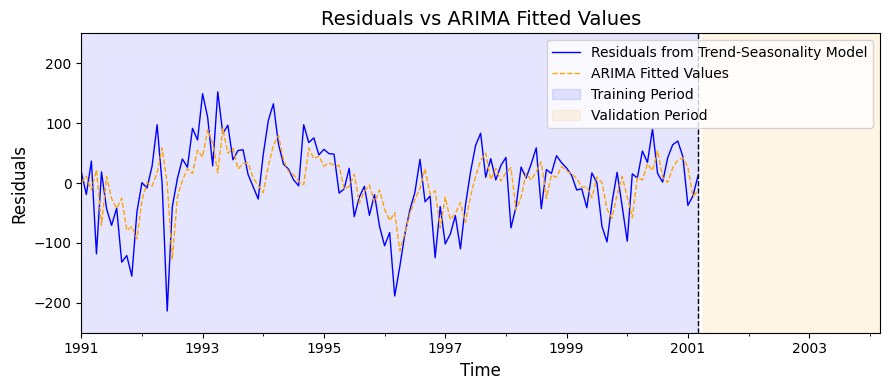

In [56]:
# Plot residuals of the trend-seasonality regression model
ax = train_lm_trendseason.resid.plot(
    figsize=(9, 4),
    label="Residuals from Trend-Seasonality Model",
    color="blue",
    linewidth=1
)

# Overlay the ARIMA model's fitted values
train_res_arima.fittedvalues.plot(
    ax=ax,
    label="ARIMA Fitted Values",
    color="orange",
    linestyle="--",
    linewidth=1
)

# Apply custom layout to the plot
singleGraphLayout(
    ax=ax,                      # Axes object to apply layout
    ylim=[-250, 250],           # Set y-axis limits for better visualization
    train_df=train_df,          # Training data for layout adjustments
    valid_df=valid_df           # Validation data for layout adjustments
)

# Add title, labels, and legend to improve readability
ax.set_title("Residuals vs ARIMA Fitted Values", fontsize=14)
ax.set_xlabel("Time", fontsize=12)
ax.set_ylabel("Residuals", fontsize=12)
ax.legend(loc="upper right")    # Add a legend to differentiate the plots

# Display the plot
plt.tight_layout()
plt.show()


## AR Model in S&P500 Monthly Closing Price

          coef     std err
0   888.299569  198.917096
1     0.983360    0.015867
2  2776.554857  382.782324


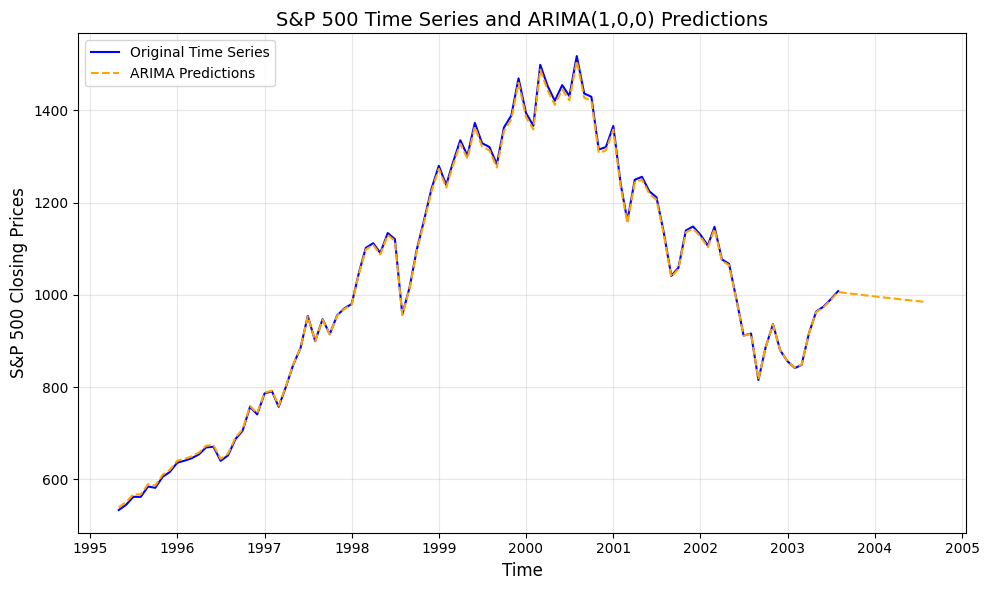

          coef     std err
0   888.299569  198.917096
1     0.983360    0.015867
2  2776.554857  382.782324


In [57]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Load and preprocess the data
sp500_df = pd.read_csv(my_drive_path + 'SP500.csv')

# Convert date to first of each month and make it a PeriodIndex
sp500_df['Date'] = pd.to_datetime(sp500_df.Date, format='%d-%b-%y').dt.to_period('M')

# Create the time series
sp500_ts = pd.Series(sp500_df.Close.values, index=sp500_df.Date, name='sp500')

# Convert the series to float array for ARIMA modeling
sp500_ts_values = sp500_ts.values

# Fit an ARIMA(1,0,0) model to the data
sp500_arima = ARIMA(sp500_ts_values, order=(1, 0, 0)).fit()

# Print the ARIMA coefficients and standard errors
print(pd.DataFrame({'coef': sp500_arima.params, 'std err': sp500_arima.bse}))

# Generate predictions using the ARIMA model
pred_values = sp500_arima.predict(start=1, end=len(sp500_ts) + 12, dynamic=False)

# Align predictions with the time index of the original data
future_dates = pd.period_range(start=sp500_ts.index[0], periods=len(pred_values), freq='M')
future_dates = future_dates.to_timestamp()  # Convert to DatetimeIndex for plotting
pred_series = pd.Series(pred_values, index=future_dates)

# Convert original time series index to DatetimeIndex
sp500_ts.index = sp500_ts.index.to_timestamp()

# Plot the original time series and predicted values
plt.figure(figsize=(10, 6))

# Plot the original time series
plt.plot(sp500_ts.index, sp500_ts_values, label='Original Time Series', color='blue', linewidth=1.5)

# Overlay predicted values
plt.plot(pred_series.index, pred_series, label='ARIMA Predictions', linestyle='dashed', color='orange', linewidth=1.5)

# Add title, labels, and legend
plt.title('S&P 500 Time Series and ARIMA(1,0,0) Predictions', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('S&P 500 Closing Prices', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

# Print coefficients and standard errors
print(pd.DataFrame({'coef': sp500_arima.params, 'std err': sp500_arima.bse}))
